# Processing diffuse scattering for mac1 dataset H6

## Background images

Import using DIALS

```bash
cd /nfs/chess/user/spm82/mdx/als_20250624/macrodomain_H6
mkdir -p dials_background
cd dials_background
dials.import /nfs/chess/scratch/user/spm82/als_20250624/macro/6-23-25/Plate1_H6/H6_air_7_*.cbf image_range=1,90 
```

Note, if you use template=stuff_#####.cbf instead, it only loads the first header, and the rest of the exposure times in imported.expt are zero! This produces infinities in output of mdx2.bin_image_series

## mdx2 processing

```bash
cd /nfs/chess/user/spm82/mdx/als_20250624/macrodomain_H6
mkdir -p mdx2
cd mdx2
mdx2.import_data ../dials_background/imported.expt --chunks 5 211 493 --nproc 5 --outfile bkg_data.nxs
mdx2.bin_image_series bkg_data.nxs 5 20 20 --valid_range 0 100 --outfile binned.nxs
mdx2.import_data ../dials/DataFiles/AUTOMATIC_DEFAULT_scaled.expt --chunks 50 211 493 --nproc 5
mdx2.import_geometry ../dials/DataFiles/AUTOMATIC_DEFAULT_scaled.expt
mdx2.find_peaks geometry.nxs data.nxs --count_threshold 20 --nproc 64
mdx2.mask_peaks geometry.nxs data.nxs peaks.nxs --sigma_cutoff 3 --nproc 64
mdx2.integrate geometry.nxs data.nxs --mask mask.nxs --subdivide 2 2 4 --nproc 64
mdx2.correct geometry.nxs integrated.nxs --background binned.nxs
mdx2.scale corrected.nxs --mca2020
mdx2.merge corrected.nxs --scale scales.nxs
```

In [4]:
!mdx2.version

mdx2: 1.0.0


## mdx2 scaling model

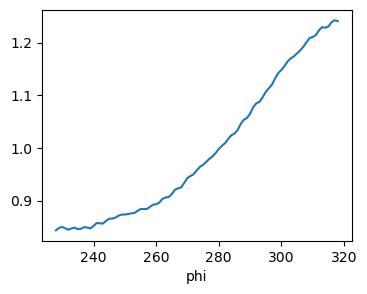

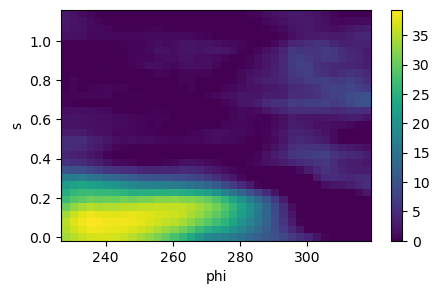

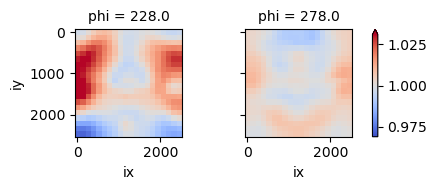

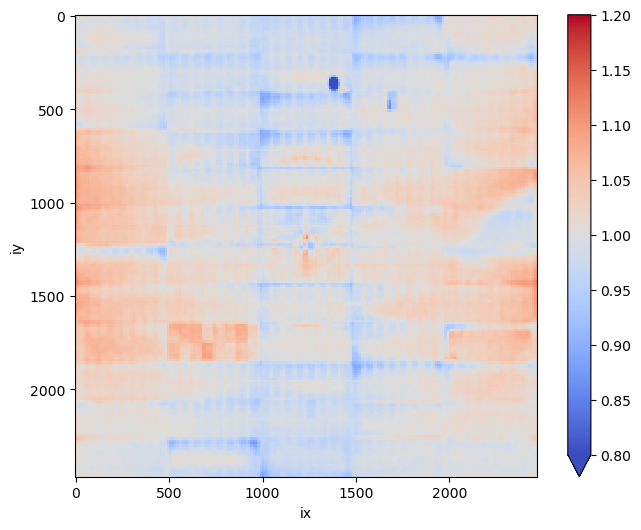

In [5]:
### mdx2 scaling model

from mdx2.utils import loadobj
import matplotlib.pyplot as plt

Models = {v:loadobj('mdx2/scales.nxs',v,verbose=False) for v in ['scaling_model','offset_model','absorption_model','detector_model']}

b = Models['scaling_model'].to_xarray()
b.plot(figsize=(4,3))

c = Models['offset_model'].to_xarray()
(c*1E-6).plot(figsize=(5,3))
a = Models['absorption_model'].to_xarray()
vr = 5*a.std().data
fh = a[:,:,::10].plot(yincrease=False,x='ix',y='iy',col='phi',figsize=(5,2),cmap='coolwarm',vmin=1-vr,vmax=1+vr)
[ax.set_aspect('equal') for ax in fh.axs.flatten()]
d = Models['detector_model'].to_xarray()
vr = .2
fh = d.plot(yincrease=False,x='ix',y='iy',figsize=(8,6),cmap='coolwarm',vmin=1-vr,vmax=1+vr)
plt.gca().set_aspect('equal')


## Isotropic average

In [6]:
from mdx2.utils import loadobj, saveobj
import pandas as pd
import numpy as np

Crystal  = loadobj('mdx2/geometry.nxs','crystal')
Symmetry = loadobj('mdx2/geometry.nxs','symmetry')

def hkl2s(h,k,l):
    """Compute the magnitude of s from Miller indices."""
    UB = Crystal.ub_matrix
    s = UB @ np.stack((h,k,l))
    return np.sqrt(np.sum(s*s,axis=0))

def isInteger(h):
    return (h.round()-h).abs() < 0.00001

def isReflection(h,k,l):
    return isInteger(h) & isInteger(k) & isInteger(l) & Symmetry.is_reflection(h,k,l)

def calc_stats(fn):
    # load the tables and convert to pandas dataframe
    tab = loadobj(fn,'hkl_table')
    tab.s = hkl2s(tab.h,tab.k,tab.l)
    df = tab.to_frame()
    df = df[~isReflection(df['h'],df['k'],df['l'])]
    df = df.set_index(['h','k','l']).sort_index()
    s_bins = pd.cut(df['s'],np.linspace(0,1,101))
    df_isoavg = df.groupby(s_bins).agg({
        's':'mean',
        'intensity':['mean','std'],
        'intensity_error':'mean'})
    
    dfh = tab.to_frame()
    dfh = dfh[isReflection(dfh['h'],dfh['k'],dfh['l'])]
    dfh = dfh.set_index(['h','k','l']).sort_index()
    s_bins = pd.cut(dfh['s'],np.linspace(0,1,101))
    dfh_isoavg = dfh.groupby(s_bins).agg({
        's':'mean',
        'intensity':['mean','std'],
        'intensity_error':'mean'})
    df_out = pd.DataFrame({'s':df_isoavg['s']['mean'],'non-halo':df_isoavg['intensity']['mean'],'halo':dfh_isoavg['intensity']['mean']})
    df_out = df_out.set_index('s')
    return df_out
    
df_stats = calc_stats(f'mdx2/merged.nxs')
nh = df_stats['non-halo'].dropna()
x = nh.keys().values
y = nh.values
Imax = np.max(y)
tab = loadobj(f'mdx2/merged.nxs','hkl_table')
tab.isoavg = np.interp(hkl2s(tab.h,tab.k,tab.l),x,y/Imax)
tab.intensity/=Imax
tab.intensity_error/=Imax
tab.intensity -= tab.isoavg
saveobj(tab,f'mdx2/merged_sub.nxs','hkl_table')

Reading crystal from mdx2/geometry.nxs
  importing as Crystal from mdx2.geometry
Reading symmetry from mdx2/geometry.nxs
  importing as Symmetry from mdx2.geometry
Reading hkl_table from mdx2/merged.nxs
  importing as HKLTable from mdx2.data
Reading hkl_table from mdx2/merged.nxs
  importing as HKLTable from mdx2.data
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to mdx2/merged_sub.nxs


NXgroup('hkl_table')

<Axes: xlabel='s'>

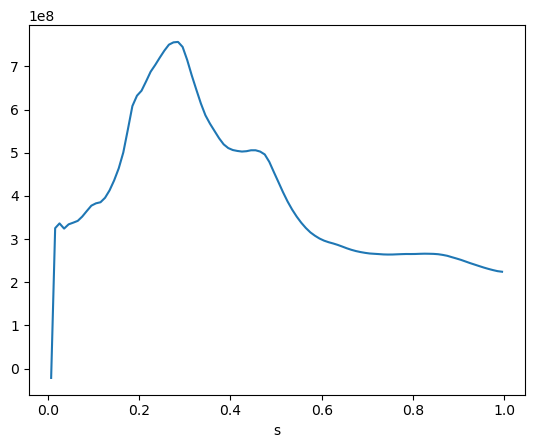

In [7]:
nh.plot()

## Map slice visualization

In [10]:
!mdx2.map mdx2/geometry.nxs mdx2/merged_sub.nxs --limits -80 80 -80 80 0 1 --signal isoavg --outfile mdx2/slice_isoavg.nxs
!mdx2.map mdx2/geometry.nxs mdx2/merged_sub.nxs --limits -80 80 -80 80 0 1 --signal intensity --outfile mdx2/slice.nxs

Reading hkl_table from mdx2/merged_sub.nxs
  importing as HKLTable from mdx2.data
Reading crystal from mdx2/geometry.nxs
  importing as Crystal from mdx2.geometry
Reading symmetry from mdx2/geometry.nxs
  importing as Symmetry from mdx2.geometry
map region:
  h from -80.0 to 80.0 (321 grid points)
  k from -80.0 to 80.0 (321 grid points)
  l from 0.0 to 1.0 (5 grid points)
generating Miller index array
mapping Miller indices to asymmetric unit
looking up isoavg in data table
preparing output array
Exporting <class 'mdx2.geometry.GridData'> to nexus object
  writing isoavg to mdx2/slice_isoavg.nxs
done!
Reading hkl_table from mdx2/merged_sub.nxs
  importing as HKLTable from mdx2.data
Reading crystal from mdx2/geometry.nxs
  importing as Crystal from mdx2.geometry
Reading symmetry from mdx2/geometry.nxs
  importing as Symmetry from mdx2.geometry
map region:
  h from -80.0 to 80.0 (321 grid points)
  k from -80.0 to 80.0 (321 grid points)
  l from 0.0 to 1.0 (5 grid points)
generating Mil

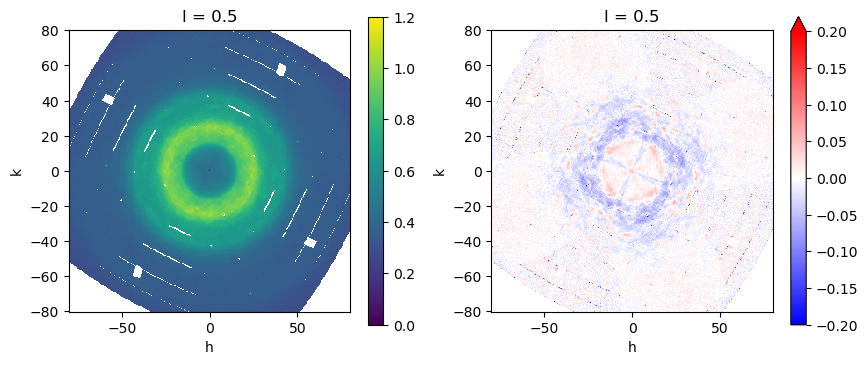

In [12]:
import matplotlib.pyplot as plt
import xarray as xr
from nexusformat.nexus import nxload
# nexpy plots commented out (use xarray instead, see below)

imav = nxload('mdx2/slice_isoavg.nxs')['/entry/isoavg']
imsub = nxload('mdx2/slice.nxs')['/entry/intensity']

im = imsub + imav

def map2xr(m):
    return xr.DataArray(
        data=m.signal.nxvalue,
        dims=m.axes,
        coords=dict(h=m.h.nxvalue, k=m.k.nxvalue, l=m.l.nxvalue)
    )

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

map2xr(im).isel(l=2).plot(x='h',y='k',ax=ax1,vmin=0,vmax=1.2,cmap='viridis')
map2xr(imsub).isel(l=2).plot(x='h',y='k',ax=ax2,vmin=-.2,vmax=.2,cmap='bwr')
ax1.set_aspect('equal')
ax2.set_aspect('equal')
#plt.savefig('mac_H6_slice_lp5.png',transparent=False)